## DreamStyler - Gram-based **StyleScore** 구현

In [1]:
import torch, torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

class VGG16Features(torch.nn.Module):
    def __init__(self, layers=None):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
        self.features = vgg.features.to(device).eval()
        self.sel = layers or [3, 8, 15, 22, 29]  # conv1_2 … conv5_3
    def forward(self, x):
        outs = []
        for i,l in enumerate(self.features):
            x = l(x)
            if i in self.sel: outs.append(x)
        return outs

pre = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [3]:
def load(p): 
    return pre(Image.open(p).convert('RGB')).unsqueeze(0)

def crop5(img_tensor, ps: int = 224):
    _, C, H, W = img_tensor.shape
    offsets = [
        (0, 0),                 # top-left
        (0, W - ps),            # top-right
        (H - ps, 0),            # bottom-left
        (H - ps, W - ps),       # bottom-right
        ((H - ps)//2, (W - ps)//2)  # center
    ]

    patches = []
    for y_off, x_off in offsets:                  # ← 좌표 변수명을 y_off, x_off 로 분리
        patch = img_tensor[:, :, y_off:y_off+ps, x_off:x_off+ps]
        patches.append(patch.squeeze(0))          # (C,ps,ps)

    return patches

def gram_vec(f):
    C,H,W = f.shape
    Fm = f.view(C,H*W)
    return (Fm@Fm.t()/(C*H*W)).flatten()

def style_score(path_I, path_S):
    I,S = load(path_I).to(device), load(path_S).to(device)
    pI,pS = crop5(I), crop5(S)
    net = VGG16Features()
    with torch.no_grad():
        gI=[[gram_vec(f.squeeze(0)).cpu() for f in net(pi.unsqueeze(0))] for pi in pI]
        gS=[[gram_vec(f.squeeze(0)).cpu() for f in net(ps.unsqueeze(0))] for ps in pS]
    L,B = len(net.sel),25
    sim=sum(F.cosine_similarity(gI[i][l],gS[j][l],dim=0).item()
            for l in range(L) for i in range(5) for j in range(5))
    return 50 - 50*sim/(L*B)

In [4]:
style_path = "/home/elicer/GramMatrix/Image/VTON-style2.jpeg"
orig_path   = "/home/elicer/GramMatrix/Image/VTON-origin2.png"
stylized_path  = "/home/elicer/GramMatrix/Image/VTON-gen2.png"

In [5]:
for p in [style_path, orig_path, stylized_path]:
    assert Path(p).exists(), f"{p} not found!"

In [6]:
score_styl = style_score(stylized_path, style_path)
score_orig = style_score(orig_path, style_path)
scores = [score_styl, score_orig]

print(f"StyleScore (Stylized vs Style): {score_styl:.2f}")
print(f"StyleScore (Original  vs Style): {score_orig:.2f}")

StyleScore (Stylized vs Style): 13.70
StyleScore (Original  vs Style): 15.31


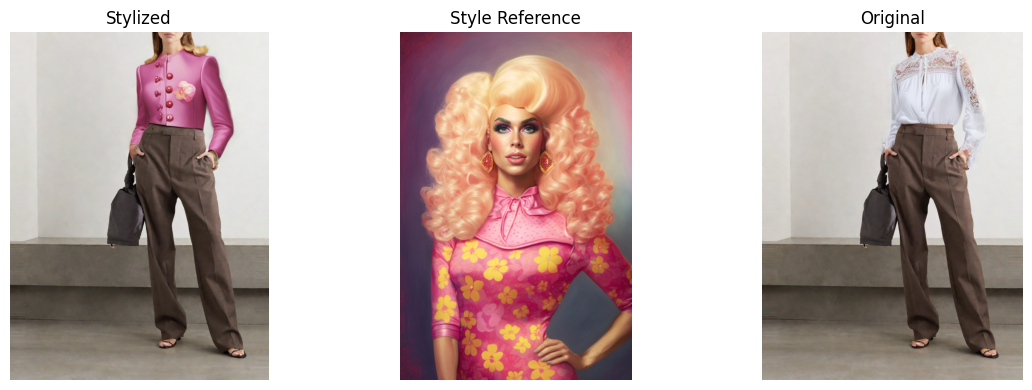

In [7]:
fig_img, ax_img = plt.subplots(1,3, figsize=(12,4))
for a,p,t in zip(ax_img,
                 [stylized_path, style_path, orig_path],
                 ["Stylized", "Style Reference", "Original"]):
    a.imshow(Image.open(p))
    a.set_title(t)
    a.axis('off')
plt.tight_layout()
plt.show()

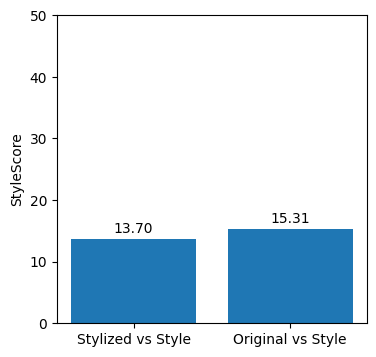

In [8]:
fig_bar, ax_bar = plt.subplots(figsize=(4,4))
ax_bar.bar(["Stylized vs Style", "Original vs Style"], scores)
ax_bar.set_ylabel("StyleScore")
ax_bar.set_ylim(0, 50)
for i,v in enumerate(scores):
    ax_bar.text(i, v + 1, f"{v:.2f}", ha='center')
plt.show()

## 차이가 얼마 안나서 마스크된 이미지로

In [9]:
style_path = "/home/elicer/GramMatrix/Image/VTON-style2.jpeg"
orig_path   = "/home/elicer/GramMatrix/Image/VTON-origin-maksed.png"
stylized_path  = "/home/elicer/GramMatrix/Image/VTON-gen-masked.png"

In [10]:
score_styl = style_score(stylized_path, style_path)
score_orig = style_score(orig_path, style_path)
scores = [score_styl, score_orig]

print(f"StyleScore (Stylized vs Style): {score_styl:.2f}")
print(f"StyleScore (Original  vs Style): {score_orig:.2f}")

StyleScore (Stylized vs Style): 13.17
StyleScore (Original  vs Style): 18.86


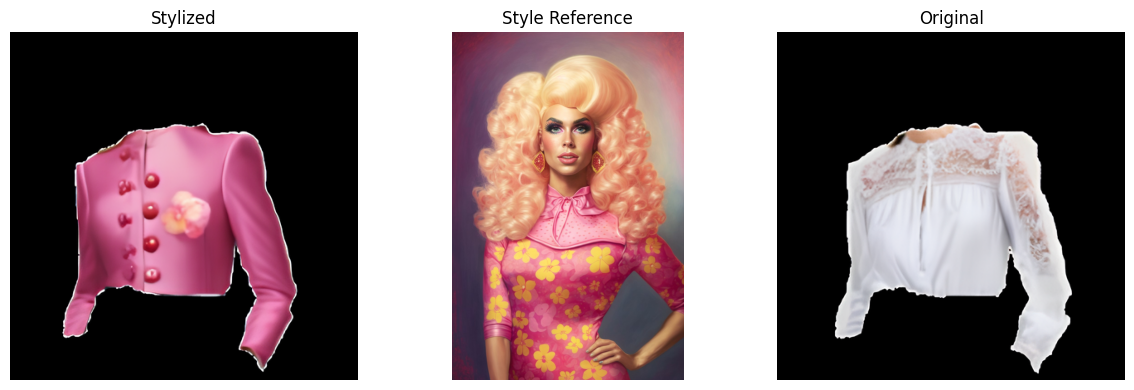

In [11]:
fig_img, ax_img = plt.subplots(1,3, figsize=(12,4))
for a,p,t in zip(ax_img,
                 [stylized_path, style_path, orig_path],
                 ["Stylized", "Style Reference", "Original"]):
    a.imshow(Image.open(p))
    a.set_title(t)
    a.axis('off')
plt.tight_layout()
plt.show()

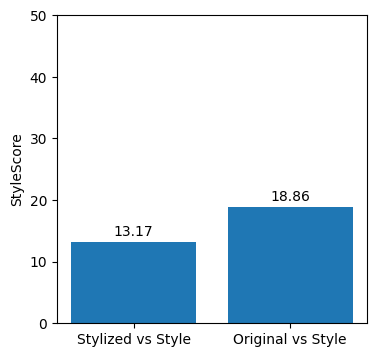

In [12]:
fig_bar, ax_bar = plt.subplots(figsize=(4,4))
ax_bar.bar(["Stylized vs Style", "Original vs Style"], scores)
ax_bar.set_ylabel("StyleScore")
ax_bar.set_ylim(0, 50)
for i,v in enumerate(scores):
    ax_bar.text(i, v + 1, f"{v:.2f}", ha='center')
plt.show()